<a href="https://colab.research.google.com/github/kotosham/sleep-stages/blob/main/MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and install libraries

In [ ]:
! pip install pytorch-lightning

In [ ]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import os
import random

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import ConcatDataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initialization

Data

In [ ]:
columns_to_read = ['1 LDF', '1 T', 'Sleep stages']
#columns_to_read = ['1 LDF', 'Sleep stages']
columns_dtype = {
    columns_to_read[0]:  'float32',
    columns_to_read[1]:  'float32',
    columns_to_read[-1]: 'int16',
 }

t_lower_bound = 35
big_file_no = 3
L_lower_threshold = 0
L_upper_threshold = 60
t_lower_threshold = 34

# Dictionary to map strings to integers
replacement_dict = {
    'W' : 0,
    'N2': 1,
    'N3': 1,
    'R' : 1
}

fragment_length = 400
num_samples = 4000
batch_size = 100
num_folds = 6

Model

In [ ]:
num_features = len(columns_to_read) - 1
num_classes = 2

# Initialize the model
input_size = fragment_length * num_features  # Assuming 2 features per fragment
hidden_size = 50

lr = 0.005
n_epochs = 100

# Supplementary functions

Pre-processing of table data

In [ ]:
def df_clean(df, columns_to_read=columns_to_read, replacement_dict=replacement_dict):
  # delete rows with nan values in a column
  df = df.dropna()
  # LDF
  df = df[df[columns_to_read[0]] > L_lower_threshold]
  df = df[df[columns_to_read[0]] < L_upper_threshold]
  # Temperature
  df = df[df[columns_to_read[1]] > t_lower_threshold]
  # the last column is for labels
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
  return df

def change_dtypes(df, columns_dtype):
  df = df.astype(columns_dtype)
  return df

In [ ]:
def plot_batch_features(features, targets, batch_idx):
    """
    Plots the features of a batch and uses the labels as captions.

    Args:
        features (torch.Tensor): The features tensor of shape (batch_size, num_features).
        targets (torch.Tensor): The targets tensor of shape (batch_size,).
        batch_idx (int): The index of the batch.
    """
    batch_size = features.shape[0]
    num_features = features.shape[1]

    fig, axes = plt.subplots(1, batch_size, figsize=(3 * batch_size, 3))

    if batch_size == 1:
        axes = [axes]  # Ensure axes is a list if batch_size is 1

    for i in range(batch_size):
        ax = axes[i]
        ax.plot(features[i].cpu().numpy())
        ax.set_title(f'Batch {batch_idx + 1}, Sample {i + 1}, Label: {targets[i].item()}')
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Feature Value')

    plt.tight_layout()
    plt.show()

In [ ]:
def vis_data(df, columns_to_read=columns_to_read):
    # Создаем фигуру с подграфиками
    num_columns = len(columns_to_read)
    fig, axes = plt.subplots(1, num_columns * 2, figsize=(15, 3))

    # Итерация по колонкам для визуализации
    for k, column in enumerate(columns_to_read):
        # Гистограмма с KDE
        sns.histplot(df[column], kde=True, ax=axes[k * 2])
        axes[k * 2].set_title(f'Distribution of {column}')
        axes[k * 2].set_xlabel(column)
        axes[k * 2].set_ylabel('Frequency')

        # Диаграмма рассеяния
        sns.scatterplot(x=df.index, y=df[column], ax=axes[k * 2 + 1])
        axes[k * 2 + 1].set_title(f'Values of {column}')
        axes[k * 2 + 1].set_xlabel('Sample ID')
        axes[k * 2 + 1].set_ylabel(column)

    # Настройка макета и отображение графиков
    plt.tight_layout()
    plt.show()

# Download data

In [ ]:
# GitHub repository URL
repo_url = "https://github.com/kotosham/sleep-stages"

# Raw files URLs
download_files = ['1.csv', '2.csv', '3-1.csv', '3-2.csv',
                  '4.csv', '5.csv', '6.csv', '7.csv']
# files_with_subfiles = ['3']

for i in download_files:
  file_url = f"{repo_url}/raw/main/{i}"
  # Download the file
  response = requests.get(file_url)
  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file
      with open(i, "wb") as file:
          file.write(response.content)
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Concatinate parts of a big file

In [ ]:
dfs = []
df_3_1 = pd.read_csv('3-1.csv', usecols=columns_to_read)
dfs.append(df_3_1)
df_3_2 = pd.read_csv('3-2.csv', usecols=columns_to_read)
dfs.append(df_3_2)
df3 = pd.concat(dfs, ignore_index=True)
df3 = df_clean(df3)
df3 = change_dtypes(df3, columns_dtype)
print(df3.head())

    1 LDF    1 T  Sleep stages
12   14.3  34.57             0
13   14.3  34.57             0
14   14.3  34.57             0
15   14.3  34.57             0
16   17.1  34.57             0


<ipython-input-5-7a50f878ded9>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Collect all the files into a list of data frames

In [ ]:
num_volunteers = (len(download_files) - 1)
files = [1]*num_volunteers
for i in range(num_volunteers):
  if i + 1 != big_file_no:
    print(i)
    f"{repo_url}/raw/main/{i}"
    files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
    files[i] = df_clean(files[i])
    files[i] = change_dtypes(files[i], columns_dtype)
files[big_file_no - 1] = df3

0
1


<ipython-input-5-7a50f878ded9>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-5-7a50f878ded9>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


3
4


<ipython-input-5-7a50f878ded9>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-5-7a50f878ded9>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


5


<ipython-input-5-7a50f878ded9>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


6


<ipython-input-10-2bf7ceac58d4>:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
<ipython-input-5-7a50f878ded9>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Means and variances

In [ ]:
alldf = pd.concat(files, axis=0)
features = alldf[columns_to_read[:-1]].values
means = features.mean(axis=0)
stds = features.std(axis=0)
del[alldf, features]
means, stds

(array([24.322649, 37.519753], dtype=float32),
 array([4.7911134, 0.5178968], dtype=float32))

Visualize all the files

Volunteer 1
Number of samples 166627


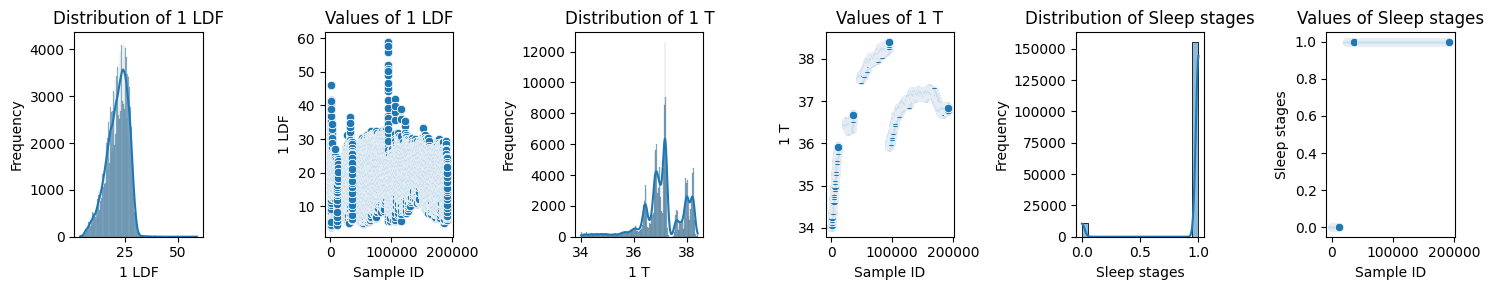

Volunteer 2
Number of samples 112848


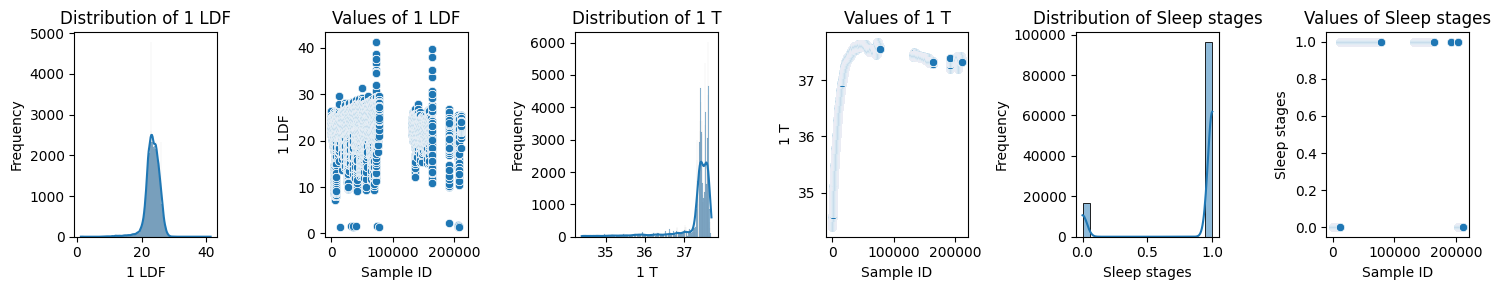

Volunteer 3
Number of samples 411736


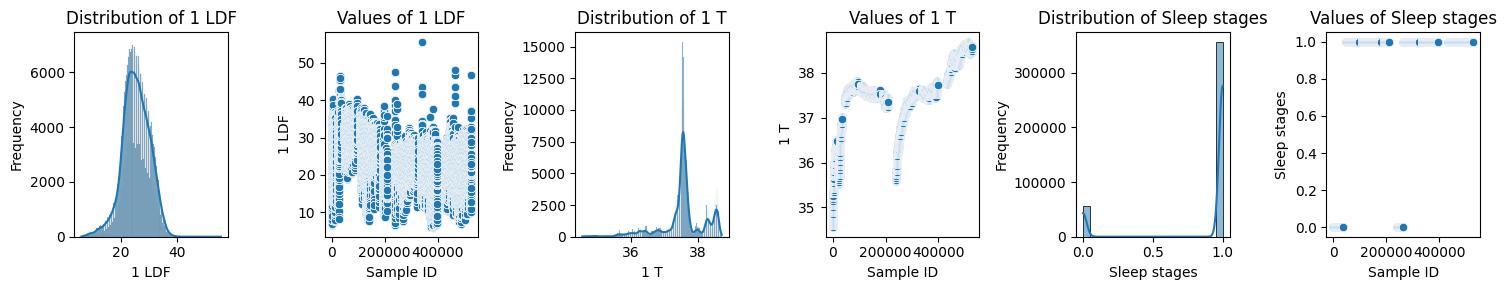

Volunteer 4
Number of samples 101844


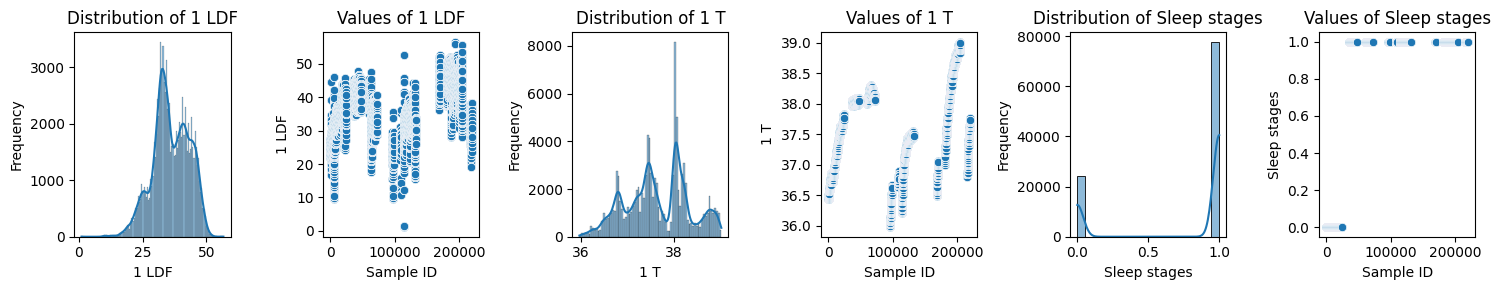

Volunteer 5
Number of samples 366509


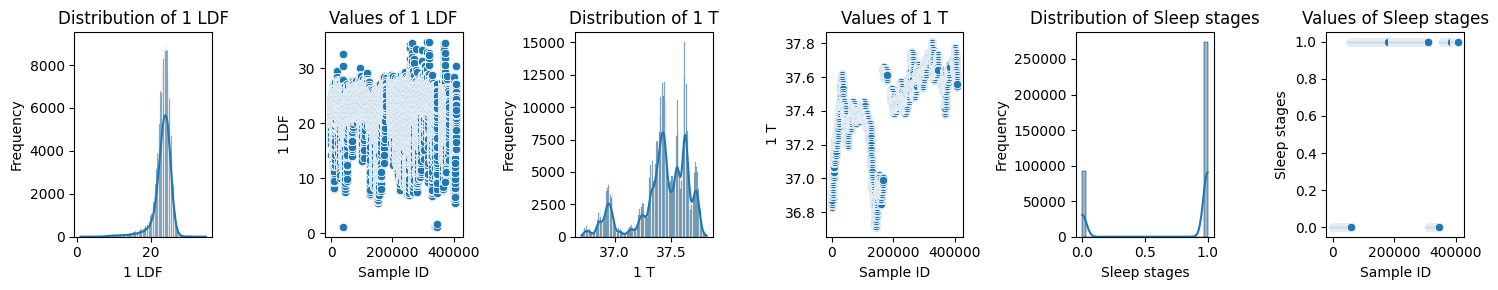

Volunteer 6
Number of samples 390907


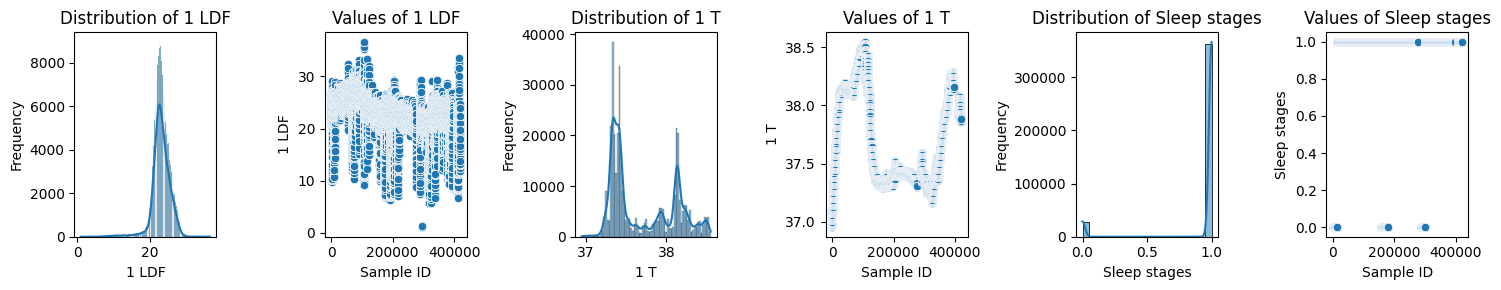

Volunteer 7
Number of samples 390757


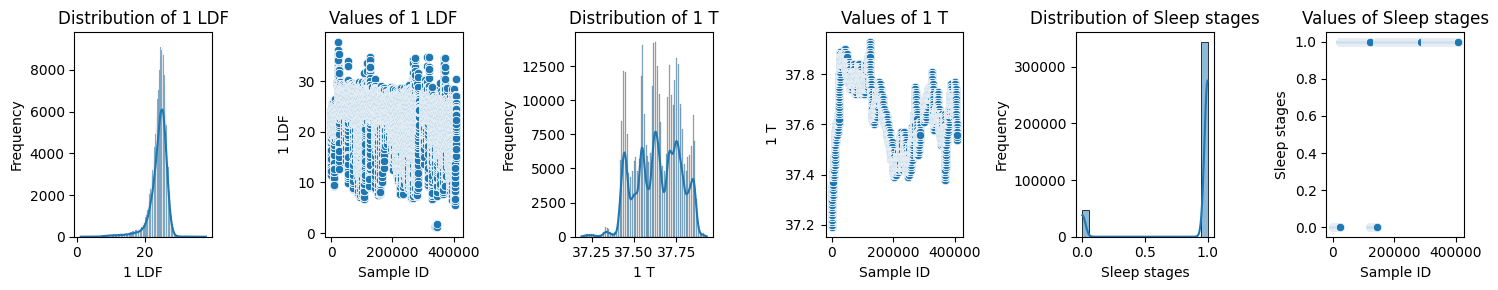

In [ ]:
for i in range(num_volunteers):
  print(f'Volunteer {i+1}')
  print(f'Number of samples {len(files[i])}')
  vis_data(files[i])

In [ ]:
files[1]

1 LDF        1 T  Sleep stages
3        24.5  34.389999             0
4        24.5  34.389999             0
5        24.5  34.389999             0
6        24.5  34.389999             0
7        24.5  34.389999             0
...       ...        ...           ...
211019   24.0  37.340000             0
211020   24.0  37.340000             0
211021   23.9  37.320000             0
211022   23.9  37.320000             0
211023   23.9  37.320000             0

[112848 rows x 3 columns]

# Dataset, dataloader, model, and training procedure

In [ ]:
class FragmentDataset(Dataset):
    def __init__(self, dataframe, fragment_length, num_samples):
        self.dataframe = dataframe
        self.fragment_length = fragment_length
        self.num_samples = num_samples
        self.data = self.load_data()

    def load_data(self):
        data = []
        class_column = self.dataframe.columns[-1]
        unique_classes = self.dataframe[class_column].unique()

        for _ in range(self.num_samples):
            selected_class = random.choice(unique_classes)
            class_data = self.dataframe[self.dataframe[class_column] == selected_class]
            if len(class_data) < self.fragment_length:
                continue  # Пропускаем, если недостаточно данных для фрагмента

            start_idx = random.randint(0, len(class_data) - self.fragment_length)
            fragment = class_data.iloc[start_idx:start_idx + self.fragment_length].values
            fragment = torch.tensor(fragment[:, :-1], dtype=torch.float32)  # Признаки
            label = torch.tensor(int(selected_class), dtype=torch.long)  # Метка
            fragment = fragment.flatten()
            data.append((fragment, label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fragment, label = self.data[idx]
        return fragment, label


class FragmentDataModule(pl.LightningDataModule):
    def __init__(self, files, fragment_length=400, num_samples=4000, batch_size=100, num_folds=6):
        self.files = files
        self.fragment_length = fragment_length
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.num_folds = num_folds

    def setup(self, stage=None):
        self.datasets = [FragmentDataset(df, self.fragment_length, self.num_samples) for df in self.files]
        self.kfold = KFold(n_splits=self.num_folds)

    def train_dataloader(self, train_indices):
        train_datasets = [self.datasets[i] for i in train_indices]
        return DataLoader(torch.utils.data.ConcatDataset(train_datasets), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self, val_indices):
        val_datasets = [self.datasets[i] for i in val_indices]
        return DataLoader(torch.utils.data.ConcatDataset(val_datasets), batch_size=self.batch_size)

    def test_dataloader(self, test_index):
        test_dataset = self.datasets[test_index]
        return DataLoader(test_dataset, batch_size=self.batch_size)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# Определение класса MLPModel для PyTorch Lightning
class MLPModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPModel, self).__init__()
        self.model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)

        preds = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y.cpu(), preds.cpu())

        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())

        # Логирование потерь и точности валидации
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)

        self.log('test_loss', loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

### Обучение моделей

In [ ]:
data_module = FragmentDataModule(files)
data_module.setup()

### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Выполнение кросс-валидации и обучение модели на каждом фолде с использованием дерева решений с гиперпараметрами
for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    # Подготовка данных для дерева решений
    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch  # Распаковка кортежа
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)  # Объединяем в двумерный массив
    y_train = np.concatenate(y_train)  # Объединяем метки в одномерный массив

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch  # Распаковка кортежа
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)  # Объединяем в двумерный массив
    y_val = np.concatenate(y_val)  # Объединяем метки в одномерный массив

    # Инициализация и обучение модели дерева решений с настройкой гиперпараметров
    model_dt = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        criterion='gini'
    )

    model_dt.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_dt.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    # Подготовка тестовых данных для дерева решений
    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch  # Распаковка кортежа
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)  # Объединяем в двумерный массив
    y_test = np.concatenate(y_test)  # Объединяем метки в одномерный массив

    # Тестирование модели на тестовом наборе
    test_preds = model_dt.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.7362
Test Accuracy for Fold 1: 0.4650
Fold 2
Validation Accuracy for Fold 2: 0.5815
Test Accuracy for Fold 2: 0.5192
Fold 3
Validation Accuracy for Fold 3: 0.7792
Test Accuracy for Fold 3: 0.3982
Fold 4
Validation Accuracy for Fold 4: 0.5840
Test Accuracy for Fold 4: 0.4520
Fold 5
Validation Accuracy for Fold 5: 0.5068
Test Accuracy for Fold 5: 0.5050
Fold 6
Validation Accuracy for Fold 6: 0.4860
Test Accuracy for Fold 6: 0.4700


### SVC model

In [ ]:
from sklearn.svm import SVC

In [ ]:
for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    # Подготовка данных для дерева решений
    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch  # Распаковка кортежа
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)  # Объединяем в двумерный массив
    y_train = np.concatenate(y_train)  # Объединяем метки в одномерный массив

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch  # Распаковка кортежа
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)  # Объединяем в двумерный массив
    y_val = np.concatenate(y_val)  # Объединяем метки в одномерный массив

    model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')

    model_svm.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    # Подготовка тестовых данных для дерева решений
    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch  # Распаковка кортежа
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)  # Объединяем в двумерный массив
    y_test = np.concatenate(y_test)  # Объединяем метки в одномерный массив

    # Тестирование модели на тестовом наборе
    test_preds = model_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.7378
Test Accuracy for Fold 1: 0.5747
Fold 2
Validation Accuracy for Fold 2: 0.8297
Test Accuracy for Fold 2: 0.5390
Fold 3
Validation Accuracy for Fold 3: 0.9655
Test Accuracy for Fold 3: 0.5102
Fold 4
Validation Accuracy for Fold 4: 0.6360
Test Accuracy for Fold 4: 0.5050
Fold 5
Validation Accuracy for Fold 5: 0.4985
Test Accuracy for Fold 5: 0.5050
Fold 6
Validation Accuracy for Fold 6: 0.5118
Test Accuracy for Fold 6: 0.5050


### MLP model

In [ ]:
for fold, (train_indices, val_index) in enumerate(data_module.kfold.split(range(len(data_module.datasets) - 1))):
    print(f'Fold {fold + 1}')

    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_index)

    # Инициализация модели MLP для текущего фолда
    model_input_size = 400 * 2  # Длина фрагмента * количество признаков (например 2 признака)
    model_mlp = MLPModel(input_size=model_input_size, hidden_size=50, num_classes=num_classes)

    trainer = pl.Trainer(max_epochs=100)

    # Обучение модели на текущем фолде
    trainer.fit(model_mlp, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Получаем значение точности валидации из логов тренера
    val_acc = trainer.callback_metrics['val_acc'].item()
    print(f'Validation Accuracy for Fold {fold + 1}: {val_acc:.4f}')

    # Подготовка тестовых данных для текущей модели
    test_index = len(data_module.datasets) - 1  # Индекс тестового набора (например последний файл)

    test_loader = data_module.test_dataloader(test_index)

    # Тестирование текущей модели на тестовом наборе
    y_true = []
    y_pred = []

    for batch in test_loader:
        x, y = batch
        outputs = model_mlp(x)  # Используем текущую модель
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Test Accuracy for Fold {fold + 1}: {accuracy:.4f}')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Fold 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation Accuracy for Fold 1: 0.5008
Test Accuracy for Fold 1: 0.5030
Fold 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation Accuracy for Fold 2: 0.5165
Test Accuracy for Fold 2: 0.4763
Fold 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation Accuracy for Fold 3: 0.4875
Test Accuracy for Fold 3: 0.5030
Fold 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation Accuracy for Fold 4: 0.5630
Test Accuracy for Fold 4: 0.5092
Fold 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 40.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
40.2 K    Trainable params
0         Non-trainable params
40.2 K    Total params
0.161     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation Accuracy for Fold 5: 0.4877
Test Accuracy for Fold 5: 0.4955
Fold 6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Validation Accuracy for Fold 6: 0.4967
Test Accuracy for Fold 6: 0.5050


### XGBoost

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    # Подготовка данных для дерева решений
    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch  # Распаковка кортежа
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)  # Объединяем в двумерный массив
    y_train = np.concatenate(y_train)  # Объединяем метки в одномерный массив

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch  # Распаковка кортежа
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)  # Объединяем в двумерный массив
    y_val = np.concatenate(y_val)  # Объединяем метки в одномерный массив

    model_gb = XGBClassifier(
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        random_state=42,
        tree_method='gpu_hist'  # Использование GPU для обучения
    )

    # Обучение модели на текущем фолде
    model_gb.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_gb.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    # Подготовка тестовых данных для дерева решений
    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch  # Распаковка кортежа
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)  # Объединяем в двумерный массив
    y_test = np.concatenate(y_test)  # Объединяем метки в одномерный массив

    # Тестирование модели на тестовом наборе
    test_preds = model_gb.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.7675
Test Accuracy for Fold 1: 0.5430
Fold 2
Validation Accuracy for Fold 2: 0.7540
Test Accuracy for Fold 2: 0.5825
Fold 3
Validation Accuracy for Fold 3: 0.8427
Test Accuracy for Fold 3: 0.5978
Fold 4
Validation Accuracy for Fold 4: 0.6192
Test Accuracy for Fold 4: 0.5493
Fold 5
Validation Accuracy for Fold 5: 0.5168
Test Accuracy for Fold 5: 0.5740
Fold 6
Validation Accuracy for Fold 6: 0.5025
Test Accuracy for Fold 6: 0.4810


## Многоклассовая классификация

In [ ]:
replacement_dict = {
    'W': 0,
    'N2': 1,
    'N3': 2,
    'R': 3
}

num_classes = 4

In [ ]:
def df_clean(df, columns_to_read=columns_to_read, replacement_dict=replacement_dict):
  # delete rows with nan values in a column
  df = df.dropna()
  # LDF
  df = df[df[columns_to_read[0]] > L_lower_threshold]
  df = df[df[columns_to_read[0]] < L_upper_threshold]
  # Temperature
  df = df[df[columns_to_read[1]] > t_lower_threshold]
  # the last column is for labels
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
  return df

In [ ]:
dfs = []
df_3_1 = pd.read_csv('3-1.csv', usecols=columns_to_read)
dfs.append(df_3_1)
df_3_2 = pd.read_csv('3-2.csv', usecols=columns_to_read)
dfs.append(df_3_2)
df3 = pd.concat(dfs, ignore_index=True)
df3 = df_clean(df3)
df3 = change_dtypes(df3, columns_dtype)

files = [1]*num_volunteers
for i in range(num_volunteers):
  if i + 1 != big_file_no:
    print(i)
    f"{repo_url}/raw/main/{i}"
    files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
    files[i] = df_clean(files[i])
    files[i] = change_dtypes(files[i], columns_dtype)
files[big_file_no - 1] = df3

<ipython-input-19-fd89cf2840fe>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


0


<ipython-input-19-fd89cf2840fe>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


1


<ipython-input-19-fd89cf2840fe>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-19-fd89cf2840fe>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


3
4


<ipython-input-19-fd89cf2840fe>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


5


<ipython-input-19-fd89cf2840fe>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
<ipython-input-20-5faf830ee112>:15: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)


6


<ipython-input-19-fd89cf2840fe>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Volunteer 1
Number of samples 166627


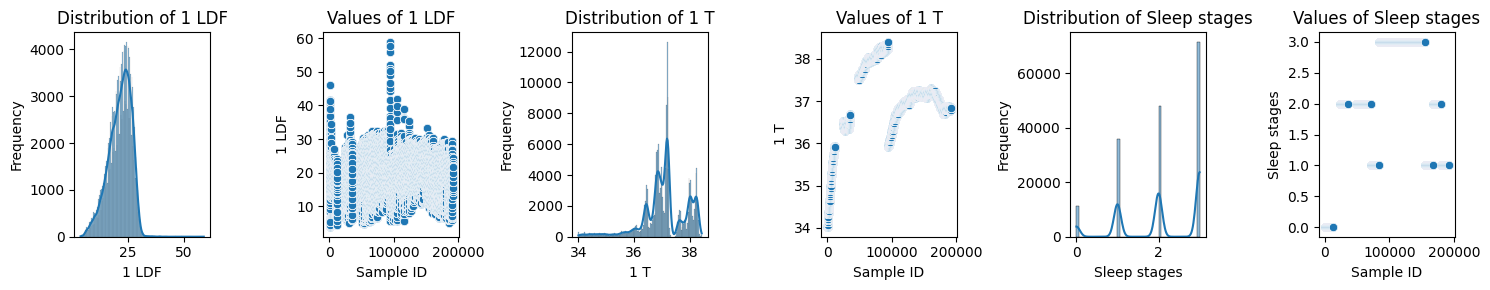

Volunteer 2
Number of samples 112848


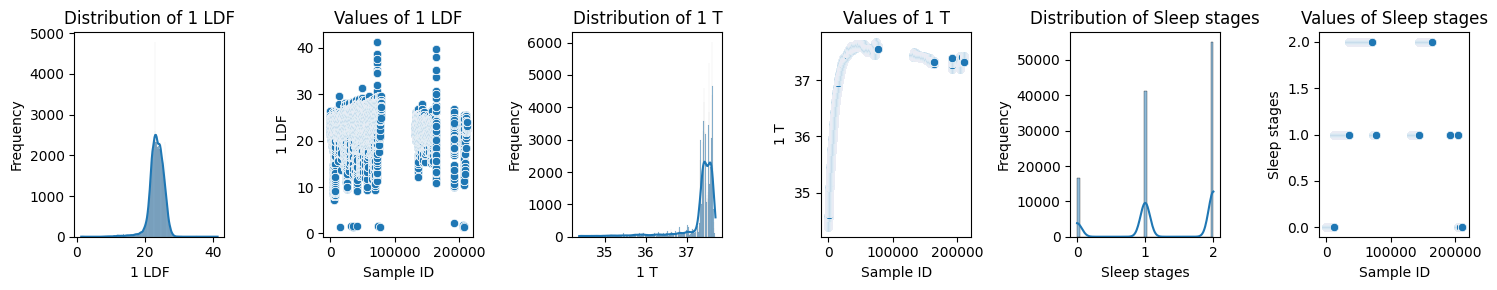

Volunteer 3
Number of samples 411736


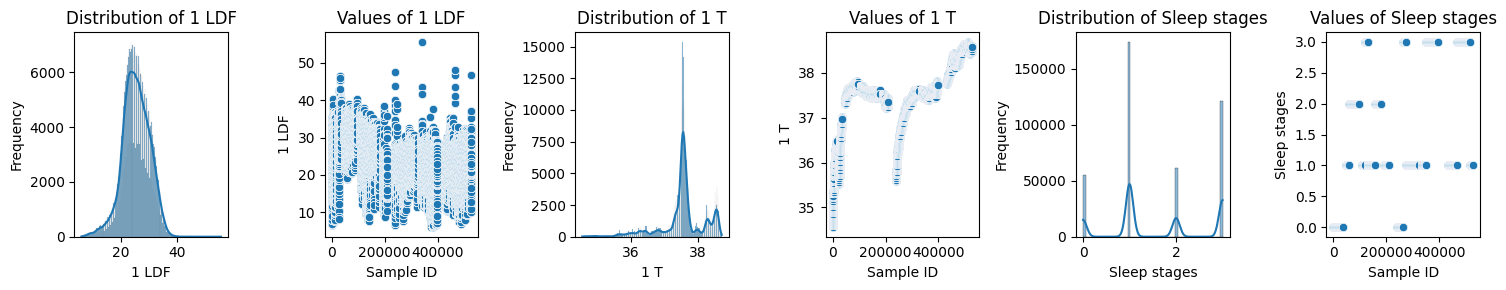

Volunteer 4
Number of samples 101844


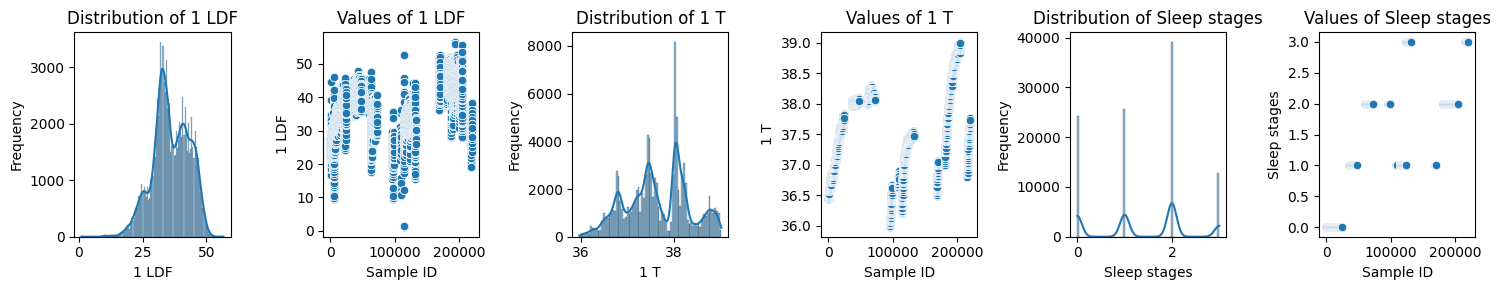

Volunteer 5
Number of samples 366509


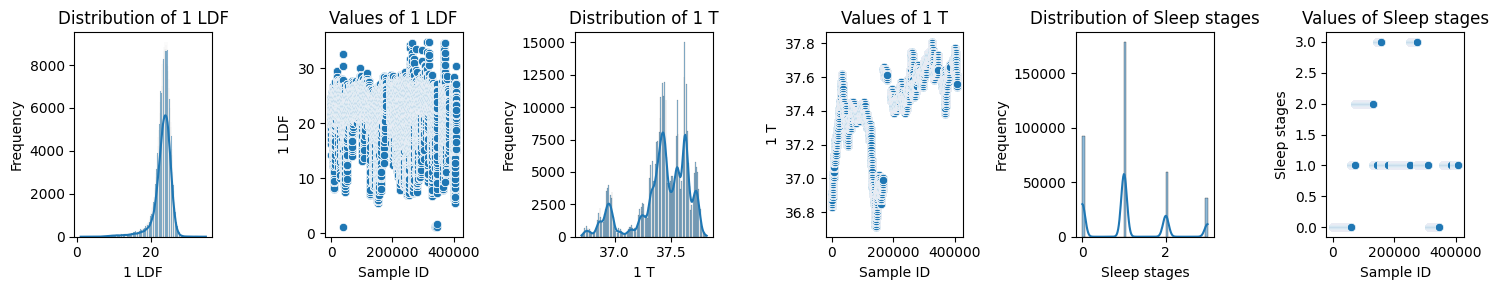

Volunteer 6
Number of samples 390907


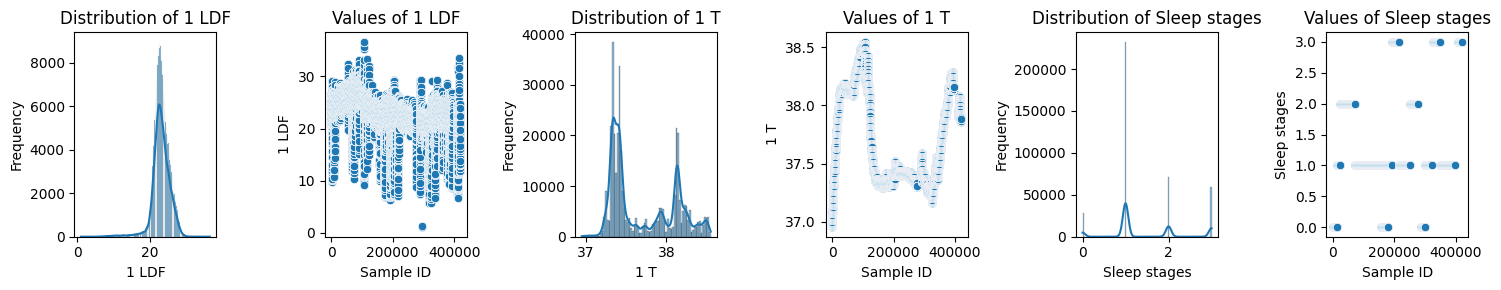

Volunteer 7
Number of samples 390757


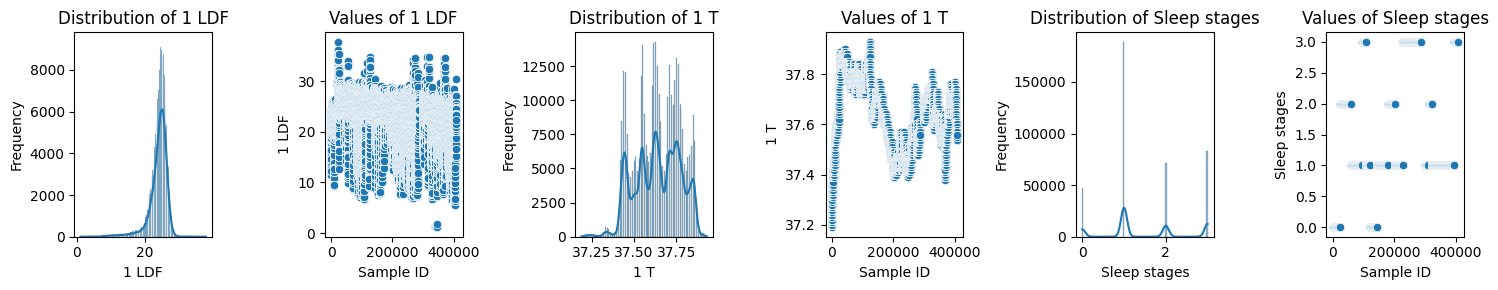

In [ ]:
for i in range(num_volunteers):
  print(f'Volunteer {i+1}')
  print(f'Number of samples {len(files[i])}')
  vis_data(files[i])

In [ ]:
data_module = FragmentDataModule(files)
data_module.setup()

### XGBoost

In [ ]:
for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    # Получаем загрузчики данных для обучения и валидации
    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    # Подготовка данных для дерева решений
    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch  # Распаковка кортежа
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)  # Объединяем в двумерный массив
    y_train = np.concatenate(y_train)  # Объединяем метки в одномерный массив

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch  # Распаковка кортежа
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)  # Объединяем в двумерный массив
    y_val = np.concatenate(y_val)  # Объединяем метки в одномерный массив

    model_xgb = XGBClassifier(
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        random_state=42,
        tree_method='gpu_hist'  # Использование GPU для обучения
    )

    # Обучение модели на текущем фолде
    model_xgb.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_xgb.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    # Подготовка тестовых данных для дерева решений
    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch  # Распаковка кортежа
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)  # Объединяем в двумерный массив
    y_test = np.concatenate(y_test)  # Объединяем метки в одномерный массив

    # Тестирование модели на тестовом наборе
    test_preds = model_xgb.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

Fold 1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 1: 0.2978
Test Accuracy for Fold 1: 0.3503
Fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:53:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 2: 0.3330
Test Accuracy for Fold 2: 0.3900
Fold 3


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 3: 0.3073
Test Accuracy for Fold 3: 0.2450
Fold 4


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 4: 0.2100
Test Accuracy for Fold 4: 0.3172
Fold 5


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 5: 0.1258
Test Accuracy for Fold 5: 0.2885
Fold 6


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 6: 0.1900
Test Accuracy for Fold 6: 0.2792


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:54:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Использовать GPU
    print("GPU is available")
else:
    device = torch.device("cpu")  # Использовать CPU
    print("GPU is not available, using CPU")

GPU is available
